# XX_MODEL_TYPE.ipynb

We will use the train/test data generated from *00_create_dataset.ipynb* and perform basic **MODEL_TYPE**

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train.csv")
test = pd.read_csv(root_dir/"data/test.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(280145, 139)
(120504, 139)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


In [ ]:
# scaling data to make it easier for models to train
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

# test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
x_test = scaler.transform(x_test)

# Remove unnecessary features
We want to remove unnecessary features to reduce the dimensionality of the model and to prevent overfitting. We will see if this improves the utility score. Since the features are anonymized, we cannot use domain knowledge to keep or remove features.

## Check covariance of features to one another
In general, we want to remove redundant features that are highly correlated.

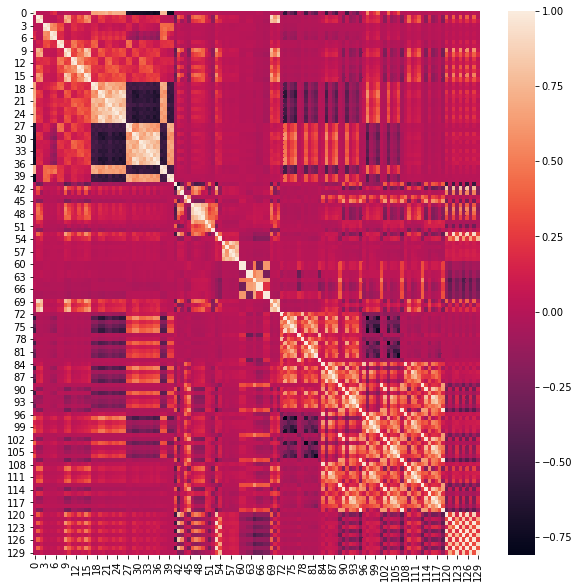

In [ ]:
import seaborn as sns

x_train_df = pd.DataFrame(x_train)
features_corr = x_train_df.corr()

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(features_corr)

We can see some strong correlation between certain features (+ve or -ve), which we can possibly reduce into lesser dimensions.

## PCA
The idea behind PCA is to take the original features and compress them into a smaller set of features, while still keeping as much information as possible. As such, if we are compressing into k features, the 1st feature will retain as much % of the variance represented by the data and so on.

The end result is k features, but of note is that the new features have no logical meaning anymore since they are representations of a few features. This is fine as our features are anonymous to begin with - but an important point is that now we have to change our original data to fit the new transformed feature space.

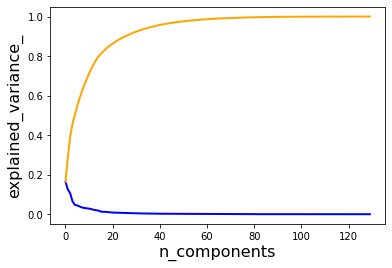

Total explained variance: 1.000 using 130 reduced features


In [ ]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(x_train)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'b', linewidth=2)
plt.plot(pca.explained_variance_ratio_.cumsum(), 'orange', linewidth=2)
plt.xlabel('n_components', fontsize=16)
plt.ylabel('explained_variance_', fontsize=16)
plt.show()

print("Total explained variance: {:.3f} using {} reduced features".format(sum(pca.explained_variance_ratio_), pca.n_components_))

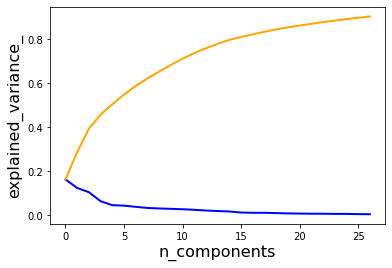

Total explained variance: 0.904 using 27 reduced features
[[ 0.18729339  0.02733572  0.02097877 ...  0.00406794  0.0325905
   0.00450518]
 [ 0.03022162 -0.14320479 -0.12277849 ... -0.03174    -0.17991095
  -0.02768013]
 [-0.01373558  0.10450514  0.10344973 ...  0.03796207  0.05903745
   0.05070885]
 ...
 [ 0.00570795  0.01931708  0.01244122 ... -0.00909944  0.00765829
   0.0185914 ]
 [-0.0169802   0.01712511 -0.02840252 ... -0.05989157  0.05463089
   0.0758898 ]
 [-0.00579053 -0.0432199   0.00671549 ... -0.11041898  0.03805409
  -0.00925603]]


In [ ]:
pca2 = decomposition.PCA(0.95)
pca2.fit(x_train)
plt.figure()
plt.plot(pca2.explained_variance_ratio_, 'b', linewidth=2)
plt.plot(pca2.explained_variance_ratio_.cumsum(), 'orange', linewidth=2)
plt.xlabel('n_components', fontsize=16)
plt.ylabel('explained_variance_', fontsize=16)
plt.show()

print("Total explained variance: {:.3f} using {} reduced features".format(sum(pca2.explained_variance_ratio_), pca2.n_components_))

print(pca2.components_)

## Transform the data to match the new reduced features

In [ ]:
x_train = pca2.transform(x_train)
x_test = pca2.transform(x_test)

# Helper functions

In [ ]:
# constants
SEED = 42

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test=test, x_test=x_test, y_test=y_test):
  y_pred = model.predict(x_test) 

  print("Utility score: ", utility_score(test, y_pred))
  print("Accuracy: ", accuracy_score(y_test, y_pred))
  
  print("Confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(3, 3))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()  

  print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

# Try a random forest classifier

Utility score:  194.58095614813584
Accuracy:  0.5140742216026024
Confusion matrix


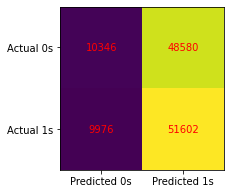

AUC_ROC


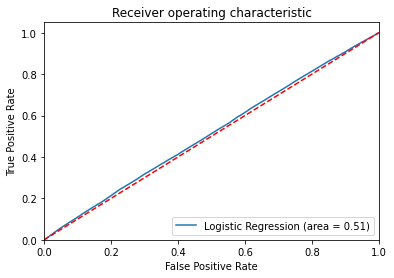

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=42)

model = rfc.fit(x_train, y_train)
model_scores(model)